In [46]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

plt.style.use('Solarize_Light2')

- **Load CPIAUCSL data**

In [47]:
CPIAUCSL_df = pd.read_csv('data/inflation/CPIAUCSL.csv')

CPIAUCSL_df['DATE'] = pd.to_datetime(CPIAUCSL_df['DATE'])
CPIAUCSL_df.set_index('DATE', inplace=True)

CPIAUCSL_df['^ %'] = CPIAUCSL_df['CPIAUCSL'].pct_change()

CPIAUCSL_df.tail()

,CPIAUCSL,^ %
DATE,,
2024-06-01,313.049,-0.000562
2024-07-01,313.534,0.001549
2024-08-01,314.121,0.001872
2024-09-01,314.686,0.001799
2024-10-01,315.454,0.002441


- **Load Real GDP data**

In [48]:
real_GDP_df = pd.read_csv('data/gdp/A191RL1Q225SBEA.csv')

real_GDP_df['DATE'] = pd.to_datetime(real_GDP_df['DATE'])
real_GDP_df.set_index('DATE', inplace=True)
real_GDP_df.columns = ['Real GDP']

real_GDP_df.tail()

,Real GDP
DATE,
2023-07-01,4.4
2023-10-01,3.2
2024-01-01,1.6
2024-04-01,3.0
2024-07-01,2.8


- **Merge the Tow**

In [49]:
df = pd.merge(CPIAUCSL_df, real_GDP_df, left_index=True, right_index=True, how='outer')

df.head(10)

,CPIAUCSL,^ %,Real GDP
DATE,,,
1947-01-01,21.48,NaN,NaN
1947-02-01,21.62,0.006518,NaN
1947-03-01,22.00,0.017576,NaN
1947-04-01,22.00,0.000000,-1.0
1947-05-01,21.95,-0.002273,NaN
1947-06-01,22.08,0.005923,NaN
1947-07-01,22.23,0.006793,-0.8
1947-08-01,22.40,0.007647,NaN
1947-09-01,22.84,0.019643,NaN


---

- **Average change**

In [50]:
print(f"Average change is {df['^ %'].mean() * 100}%")

Average change is 0.2889828295147166%


- **Overview on change**

In [51]:
positive_filter = df['^ %'] > 0
negative_filter = df['^ %'] < 0
zero_filter = df['^ %'] == 0

# count
total_items = len(df)

# average change
avg_change = [
    df[positive_filter]['^ %'].mean(),
    df[negative_filter]['^ %'].mean(),
    0,
    ""
]

# frequency
frequency = [
    df[positive_filter]['^ %'].count(),
    df[negative_filter]['^ %'].count(),
    df[zero_filter]['^ %'].count()
]
frequency.append(frequency[0]/frequency[1])

# frequency pct
frequency_pct = [100 * frequency[i]/total_items for i in range(3)]
frequency_pct.append("")

# Prob adj
prob_adj = [frequency_pct[i] * avg_change[i] for i in range(3)]
prob_adj.append("")

pd.DataFrame({
    "%": [x * 100 for x in avg_change],
    "Frequency": frequency,
    "Frequency %": frequency_pct,
    "Prob Adjust % Change": prob_adj,
}, index=["Av Pos", "Av Neg", "Zero", "Ratio P/N"])

,%,Frequency,Frequency %,Prob Adjust % Change
Av Pos,0.37391,784.000000,83.940043,0.31386
Av Neg,-0.217819,108.000000,11.563169,-0.025187
Zero,0,41.000000,4.389722,0.0
Ratio P/N,,7.259259,,


- **Stats**

In [52]:
from scipy.stats import describe

# Display the results

stats = describe(df['^ %'].dropna().tolist())
pd.DataFrame(
    {
        'value': [
            str(stats.nobs),
            stats.minmax[0] * 100,
            stats.minmax[1] * 100,
            stats.mean * 100,
            df['^ %'].median() * 100,
            df['^ %'].mode(dropna=True)[0] * 100,
            stats.variance,
            stats.skewness,
            stats.kurtosis
        ]
    },
    index=['nobs', 'Min %', 'Max %', 'Mean %', "Median", "Mode", 'Variance', 'Skewness', 'Kurtosis'],
)

,value
nobs,933
Min %,-1.770548
Max %,1.964286
Mean %,0.288983
Median,0.246914
Mode,0.0
Variance,0.000012
Skewness,0.590227
Kurtosis,4.022409


- **Data preview**

In [53]:
# Define bins
bins = [0.005 * i for i in range(-3, 4)]
bins.append(stats.minmax[1])
bins.insert(0, stats.minmax[0])
bin_labels = [
    'Less than -1.5%',
    '-1.5% to -1%',
    '-1% to -0.5%',
    '-0.5% to 0%',
    '0% to 0.5%',
    '0.5% to 1%',
    '1% to 1.5%',
    'Greater than 1.5%',
]

# Assign data to bins
binned = pd.cut(df['^ %'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate frequency, probability, and cumulative probability
frequency = binned.value_counts().sort_index()
probability = 100 * frequency / frequency.sum()
cumulative_probability = probability.cumsum()

occurrence_frequencies = pd.DataFrame({
    'Frequency': frequency.values,
    'Probability %': probability.values,
    'Cumulative Probability %': cumulative_probability.values
}, index=bin_labels)

occurrence_frequencies

,Frequency,Probability %,Cumulative Probability %
Less than -1.5%,1,0.107181,0.107181
-1.5% to -1%,0,0.000000,0.107181
-1% to -0.5%,9,0.964630,1.071811
-0.5% to 0%,139,14.898178,15.969989
0% to 0.5%,591,63.344051,79.314041
0.5% to 1%,157,16.827438,96.141479
1% to 1.5%,29,3.108253,99.249732
Greater than 1.5%,7,0.750268,100.000000


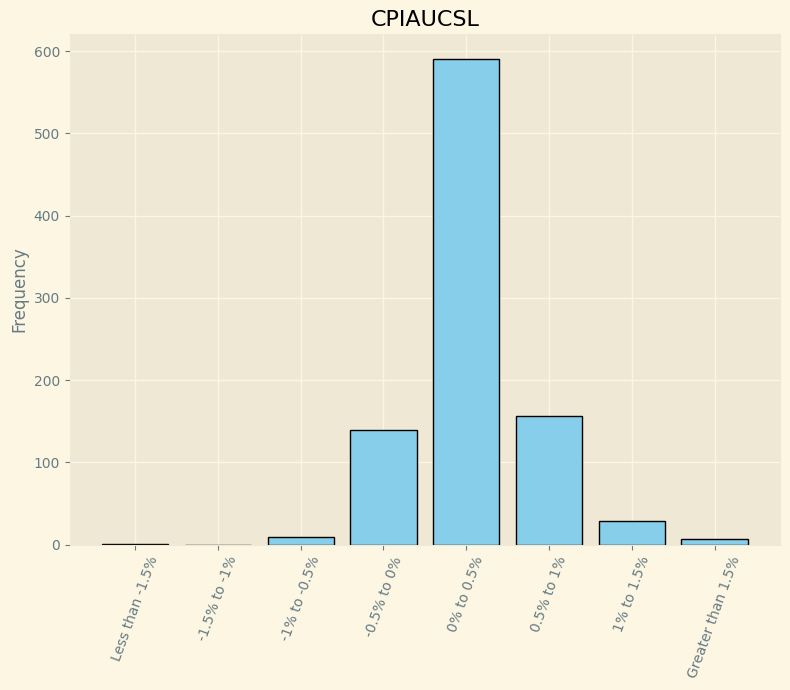

In [54]:
plt.figure(figsize=(8, 7))

plt.bar(occurrence_frequencies.index, occurrence_frequencies['Frequency'], color='skyblue', edgecolor='black')

# median_age = df['^ %'].median()
# plt.axvline(median_age, color='#fc4f30', label='Change Median')

# Add labels and title
plt.title('CPIAUCSL')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation=70) 
# Show the chart
plt.tight_layout()
plt.show();

- **Scatter plot**

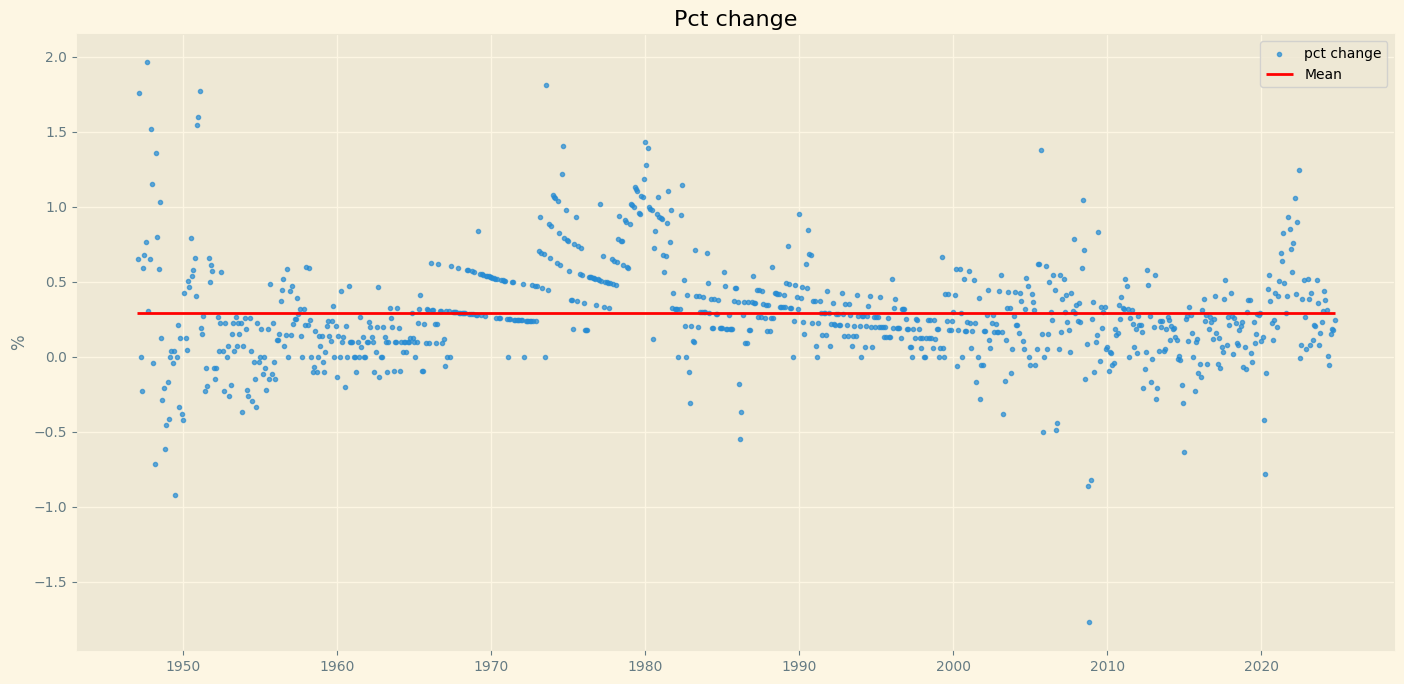

In [55]:
plt.figure(figsize=(17, 8))

plt.scatter(x=df.index, y=df['^ %']*100, alpha=.7, marker=".");
plt.plot(df.index, [100 * stats.mean] * (stats.nobs + 1), 'r');
plt.title('Pct change')
plt.ylabel('%')
plt.legend(['pct change', 'Mean']);

- **CPI data**

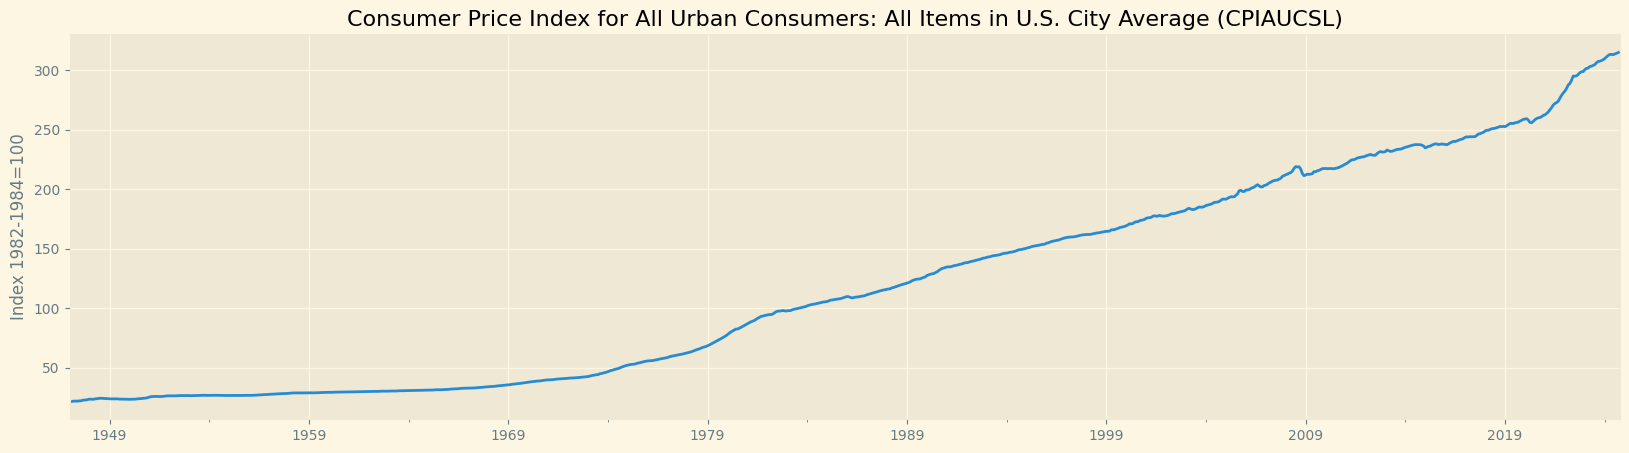

In [56]:
df['CPIAUCSL'].plot(
    figsize=(20, 5),
    xlabel='',
    ylabel='Index 1982-1984=100',
    title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)',
);

In [57]:
# (df['^ %'] * 100).plot(
#     kind='bar',
#     figsize=(30, 10),
#     xlabel='',
#     ylabel='%',
#     title='CPI',
# );

# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# plt.xticks(rotation=70);

- **CPIAUCSL vs GDP Growth**

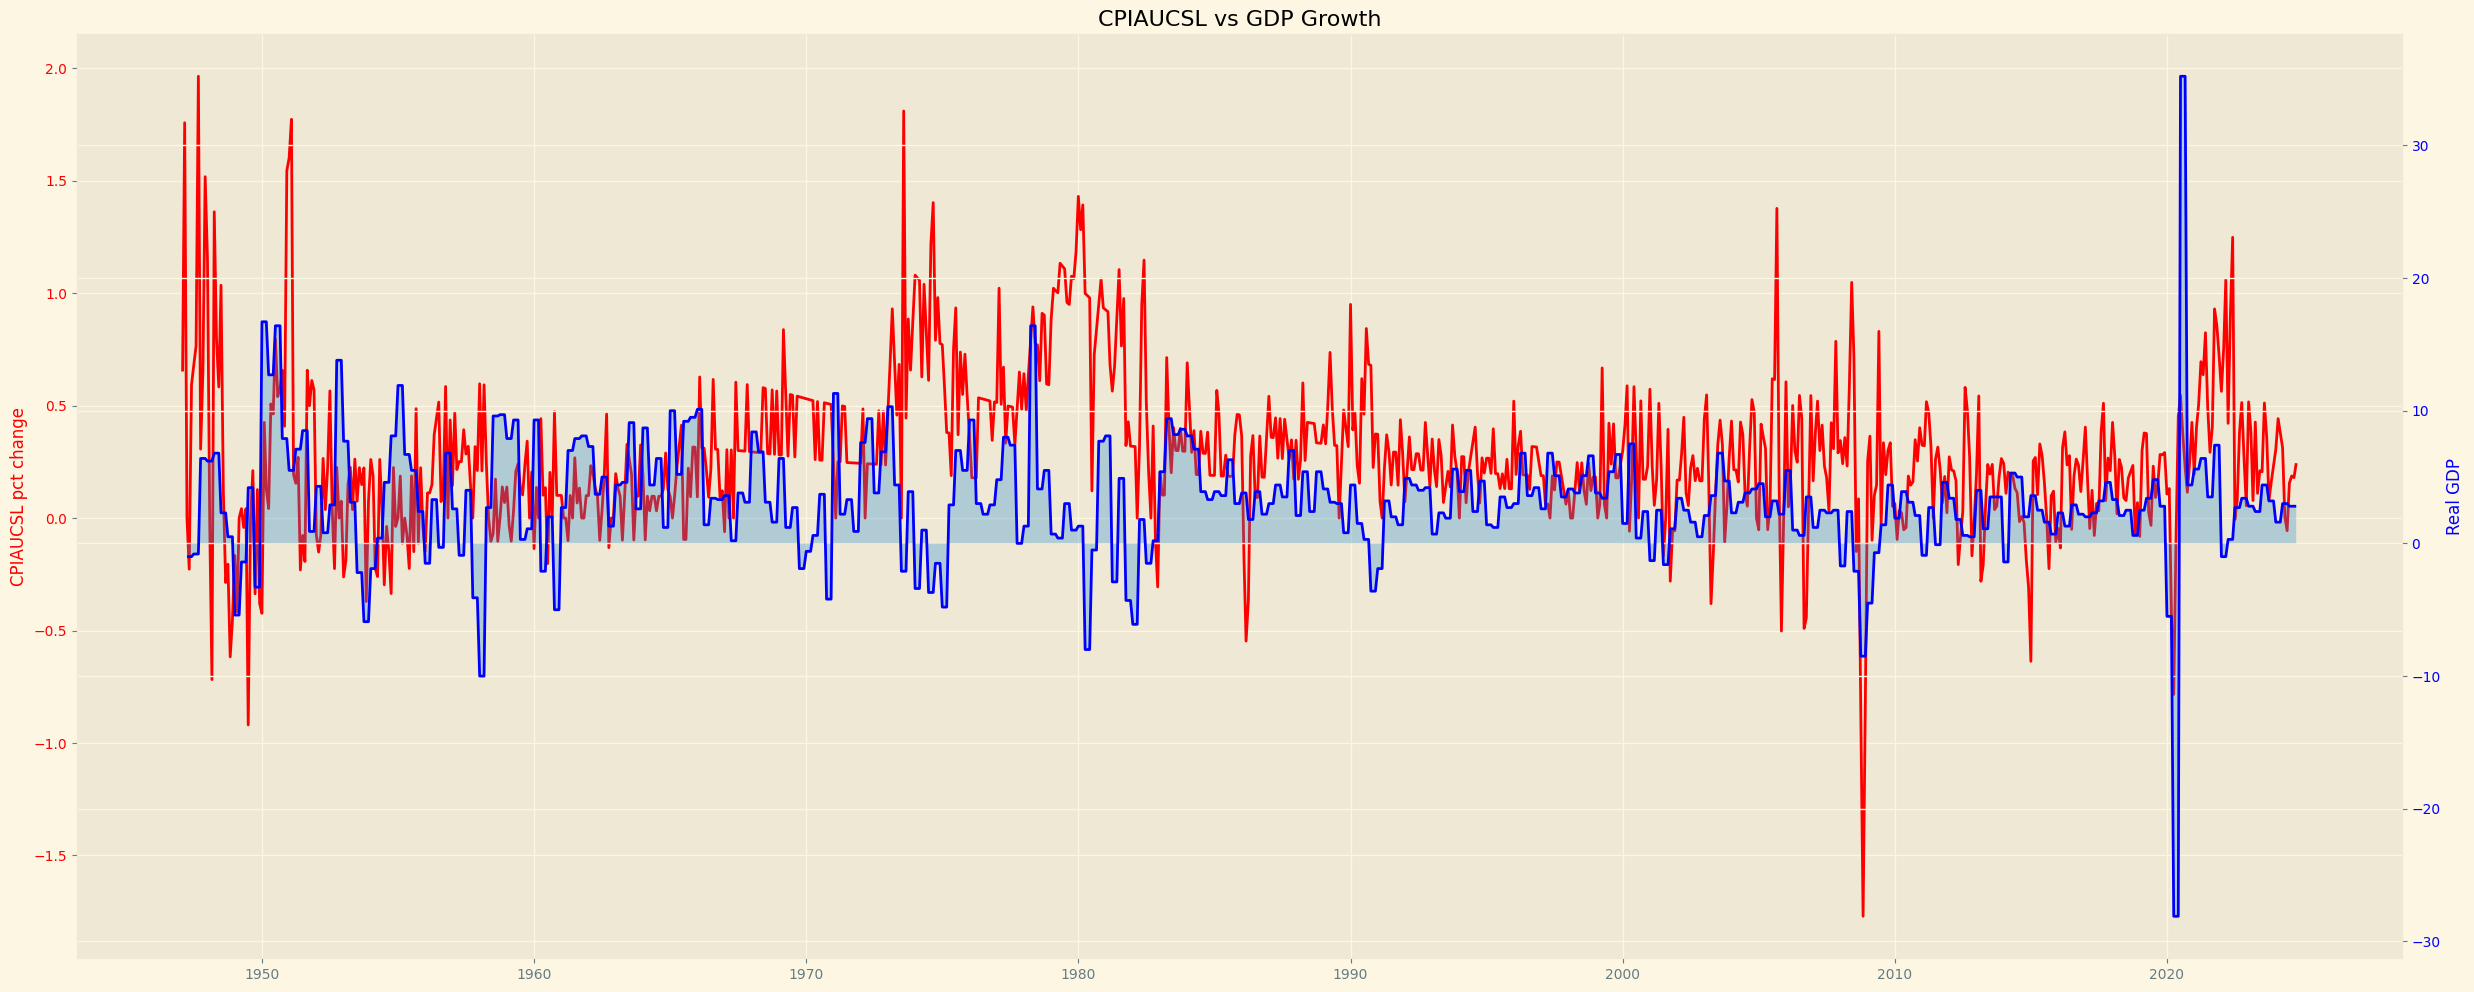

In [58]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(30, 12))

ax1.plot(df.index, df['^ %'] * 100, 'r-', label='CPIAUCSL pct change')
ax1.set_xlabel('')
ax1.set_ylabel('CPIAUCSL pct change', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()

ax2.plot(df.index, df['Real GDP'].ffill(), 'b-', label='Real GDP')
ax2.fill_between(df.index, df['Real GDP'].ffill(), alpha=.3, label='Real GDP')
ax2.set_ylabel('Real GDP', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Show the plot
plt.title('CPIAUCSL vs GDP Growth')
plt.show();


- **Last 10 years**

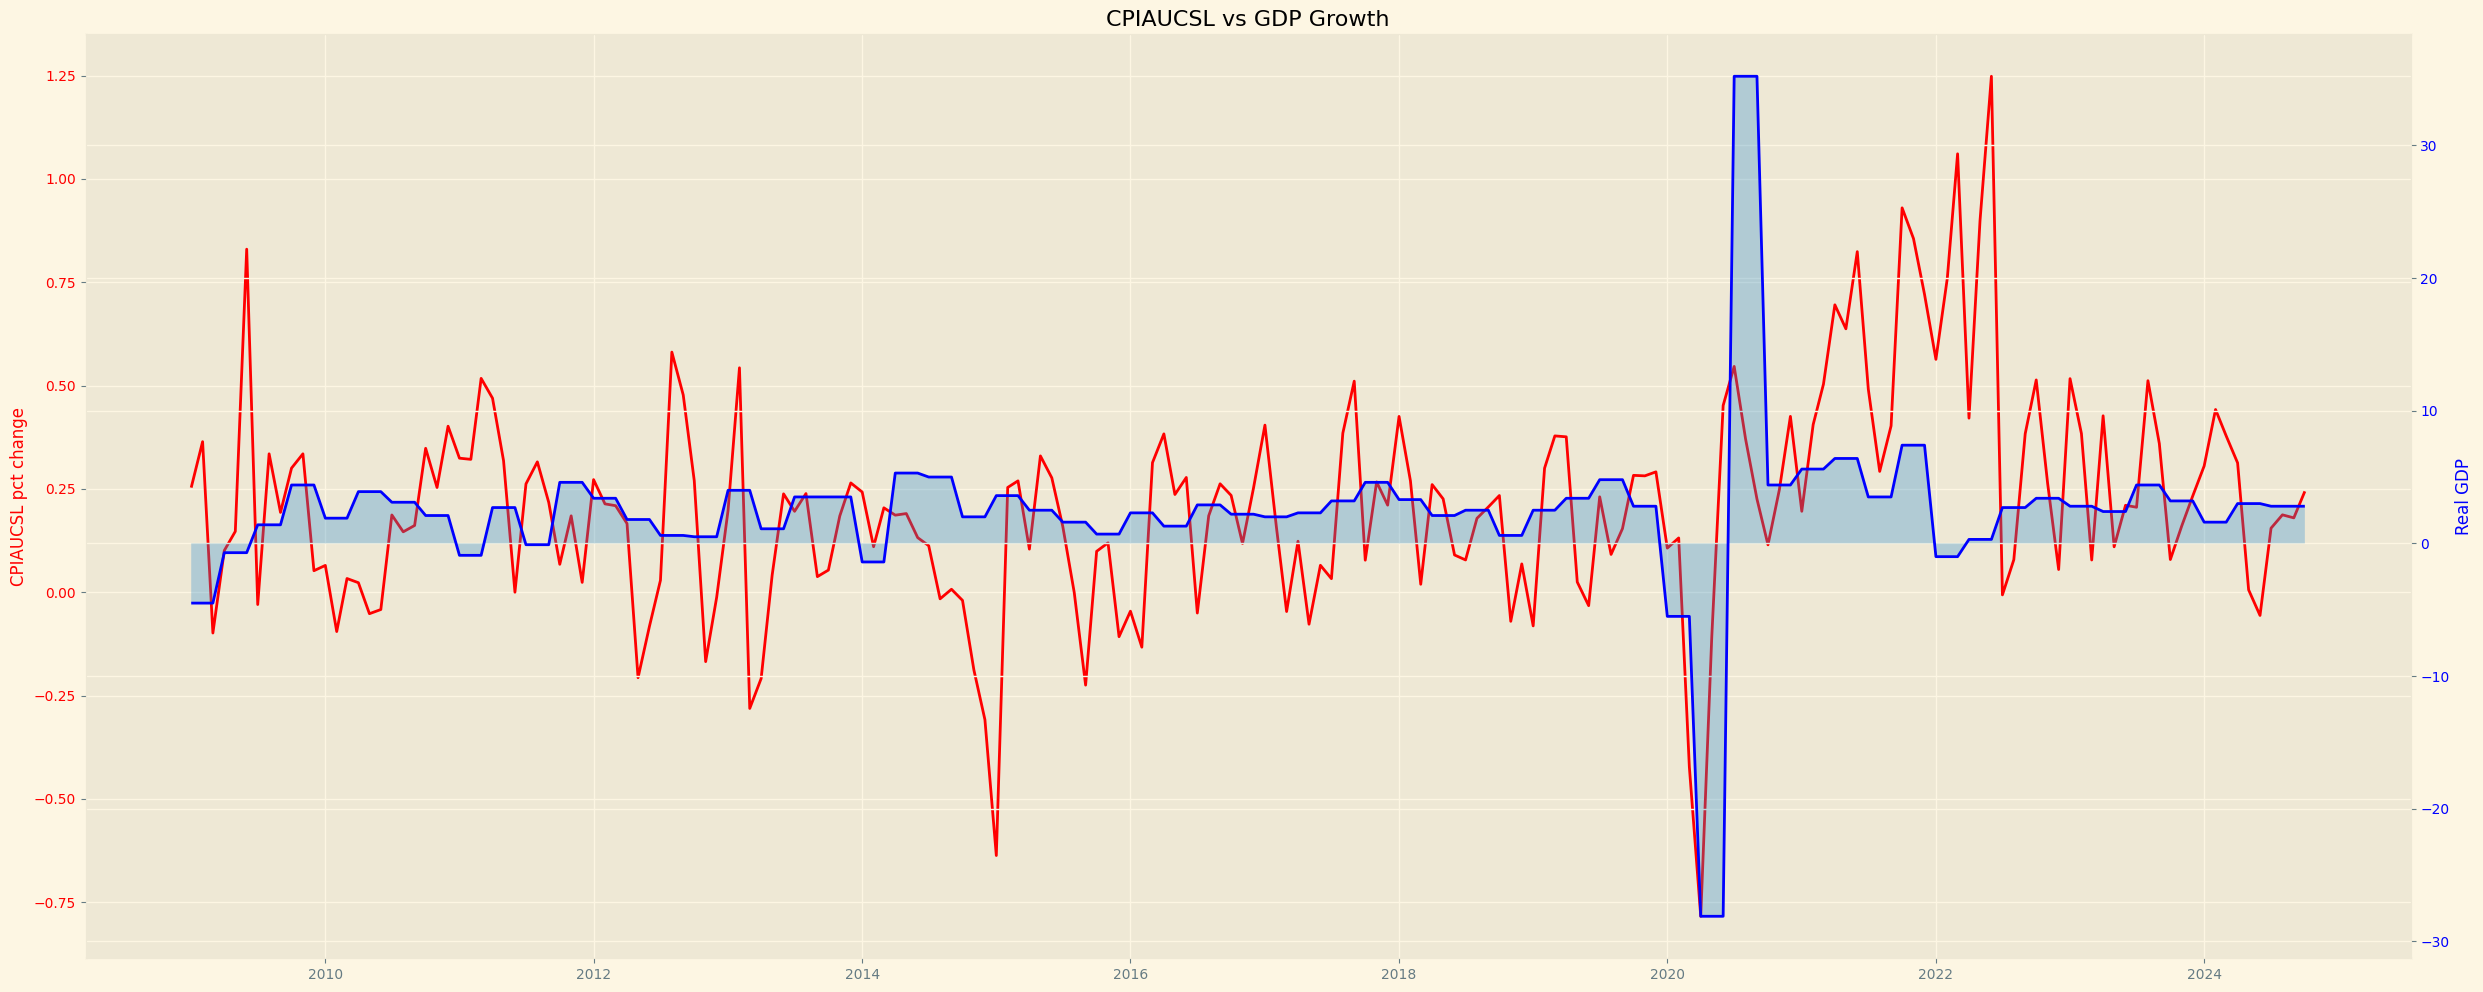

In [59]:
today = datetime.today()

last_10_years_df = df.loc[f"{today.year - 15}-01": f"{today.year}-{today.month}"]


fig, ax1 = plt.subplots(figsize=(30, 12))

ax1.plot(last_10_years_df.index, last_10_years_df['^ %'] * 100, 'r-', label='CPIAUCSL pct change')
ax1.set_xlabel('')
ax1.set_ylabel('CPIAUCSL pct change', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()

ax2.plot(last_10_years_df.index, last_10_years_df['Real GDP'].ffill(), 'b-', label='Real GDP')
ax2.fill_between(last_10_years_df.index, last_10_years_df['Real GDP'].ffill(), alpha=.3, label='Real GDP')
ax2.set_ylabel('Real GDP', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Show the plot
plt.title('CPIAUCSL vs GDP Growth')
plt.show();

---

- **Score**

In [61]:
score_df = pd.read_csv('score/CPIAUCSL.csv')

score_df

,^CPIAUCSL,GDP,Score
0,1.4,8.0,3
1,1.2,6.0,6
2,1.0,5.0,10
3,0.8,4.0,8
4,0.6,3.0,6
5,0.4,2.0,4
6,0.3,1.0,0
7,0.0,0.0,0
8,-0.1,-0.5,-6
9,-0.2,-1.0,-8


- **Current score**

In [67]:
last_CPIAUCSL_pct = df['^ %'].iloc[-1]

current_REAL_GDP = real_GDP_df.iloc[-1]['Real GDP']

last_CPIAUCSL_pct * 100, current_REAL_GDP

(0.24405280184056632, 2.8)